# Exploring your data with unsupervised machine learning


![](http://scikit-learn.org/stable/_static/ml_map.png)

## Dimensionality reduction

Dimensionality reduction algorithms like PCA, ICA, MDS, t-SNE (we'll get into the acronyms in a second) are all trying to accomplish the same thing: *smush your high dimensional data into a palatable number of dimensions* (often <10).


In [1]:

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA 
import seaborn as sns
sns.set(style='white', context='notebook')
import ipywidgets

%matplotlib inline


Automatically created module for IPython interactive environment


/Users/olga/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Matrix decomposition methods: PCA and ICA

The two first methods we will talk about are true matrix decomposition methods. They are trying to decompose a matrix $X$ into constitutent parts, $Y$ and $W$.

$Y = WX$

#### Principal Component Analysis (PCA)

Principal component analysis, statistically speaking, finds the axes of most variance in the data. Put another way, PCA finds the directions of genes that change the most across your data, then the second most changing genes, then the next.

#### Independent Component Analysis (ICA)

ICA was originally created for the "cocktail party problem" for audio processing. It's an incredible feat that our brains are able to filter out all these different sources of audio, automatically!

![](figures/Cocktail-party-_2502341b.jpg)
(I really like how smug that guy looks - it's really over the top)
[Source](http://www.telegraph.co.uk/news/science/science-news/9913518/Cocktail-party-problem-explained-how-the-brain-filters-out-unwanted-voices.html)

##### Cocktail party problem

Given multiple sources of sound (people talking, the band playing, glasses clinking), how do you distinguish independent sources of sound? Imagine at a cocktail party you have multiple microphones stationed throughout, and you get to hear all of these different sounds. 

![](figures/independent-component-analysis-ica-the-cocktail-party-problem-n.jpg)

[Source](http://www.slideserve.com/vladimir-kirkland/ica-and-isa-using-schweizer-wolff-measure-of-dependence)


##### What if you applied PCA to the cocktail party problem?

What would you get if you

Example adapted from the excellent [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html).

/Users/olga/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


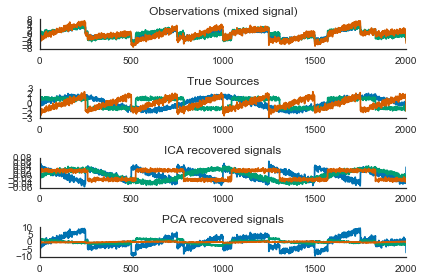

In [2]:

###############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

###############################################################################
# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = sns.color_palette('colorblind')

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
sns.despine()
plt.show()


### PCA vs ICA

Which one should you use? Well, that depends on your question :)

PCA and ICA have different goals. PCA wants to find the things that change the greatest across your data, and ICA wants to find individual signals. Let's take a look at this by running both PCA and ICA on data that we're all familiar with - faces!

The "Olivetti Faces Dataset" is a commonly use face recognition dataset in machine learning.

In [3]:
%pdb

Automatic pdb calling has been turned ON


Automatically created module for IPython interactive environment
Dataset consists of 400 faces
Extracting the top 20 Eigenfaces - PCA...
done in 0.348s
Extracting the top 20 Independent components - FastICA...
done in 0.285s


/Users/olga/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


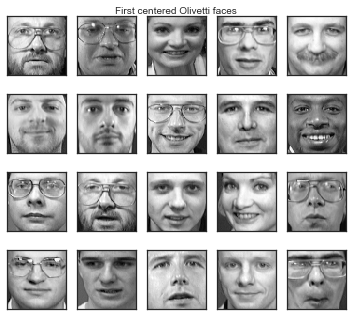

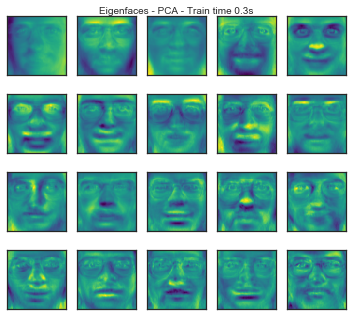

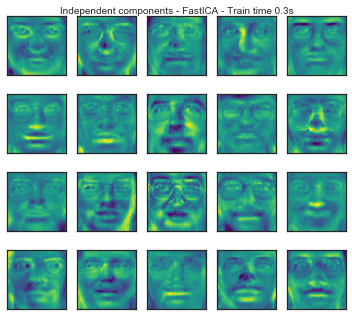

In [4]:



# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt
print(__doc__)
plt.close('all')

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 4, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

###############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


###############################################################################
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.viridis):
    plt.figure(figsize=(2. * n_col/2, 2.26 * n_row/2))
    plt.suptitle(title)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        if comp.min() < 0:
            vmax = max(comp.max(), -comp.min())
            vmin = -vmax
        else:
            vmin = comp.min()
            vmax = comp.max()
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=vmin, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

###############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses centered data
estimators = [
    ('Eigenfaces - PCA',
     decomposition.PCA(n_components=n_components, whiten=True),
     True),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, 
                           whiten=True, random_state=2016),
     True),
    
]


###############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces[:n_components], cmap=plt.cm.gray)

###############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    elif hasattr(estimator, 'components_'):
        components_ = estimator.components_
    elif hasattr(estimator, 'alphas_'):
        components_ = estimator.alphas_
#     if hasattr(estimator, 'noise_variance_'):
#         plot_gallery("Pixelwise variance",
#                      estimator.noise_variance_.reshape(1, -1), n_col=1,
#                      n_row=1)
#     cmap = plt.cm.RdBu_r if center else plt.cm.viridis
#     cmap = plt.cm.viridis
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

The first figure and its subpanels show the first 20 (out of 400) faces in the dataset. The second plot shows you the *components* of the data. 

Notice that in PCA, these are "eigenfaces," that is, the first face is the most average face that explains most of the data. The next components shows where the next largest amount of variance is. As you continue, the components of PCA goes into the edge cases of the different faces so you can reconstruct more and more faces.

For ICA, we don't get an "eigenface." Instead, ICA goes right into the discrete signals. Notice that some of the ICA components actually look like an individual person's face, not an average of people's faces. ICA is pulling out individual people who had their photo taken multiple times in the dataset, and reconstructing them.

#### The punchline

Which should you use, PCA or ICA? Again, it depends on your question!

PCA tells you which are the largest varying genes in your data. ICA tells you which genes contribute to discrete signals from specific populations in your data.

### Manifold learning dimensionality reduction: MDS and t-SNE



In [5]:
cmap = plt.cm.viridis

# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

import scipy
from time import time
import warnings

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

def compare_mds_tsne(n_points=1000, random_state=0, stddev=0, metric='euclidean', tsne_init='pca'):
#     n_points = 2000
    X, sample_order = datasets.samples_generator.make_s_curve(n_points, random_state=0)

    if stddev > 0:
        X = X + np.random.normal(size=np.product(X.shape), scale=0.1).reshape(X.shape)
        

    fig = plt.figure(figsize=(12, 4))
    plt.suptitle("Manifold Learning with %i points" % (n_points))
    
    # Plot original data
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=sample_order, cmap=cmap)
    ax.view_init(4, -72)

    # Add noise if necessary
    n_components = 2
    smusher_kws = dict(n_components=n_components, random_state=random_state)
    tsne_kws = dict(init=tsne_init)
    
    if metric != 'euclidean':
        X = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X, metric=metric))
        smusher_kws['metric'] = 'precomputed'
        
        warnings.warn('FYI not initializing t-SNE with PCA since distances are precomputed')
        tsne_kws.pop('init')
    tsne_kws.update(smusher_kws)
    

    # Perform MDS and plot it
    t0 = time()
    mds = manifold.MDS(max_iter=100, n_init=1, **smusher_kws)
    Y = mds.fit_transform(X)
    t1 = time()
    print("MDS: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[:, 0], Y[:, 1], c=sample_order, cmap=cmap)
    plt.title("MDS (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    # Perform t-SNE and plot it
    t0 = time()
    tsne = manifold.TSNE(**tsne_kws)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(1,3,3)
    plt.scatter(Y[:, 0], Y[:, 1], c=sample_order, cmap=cmap)
    plt.title("t-SNE (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()
    


Automatically created module for IPython interactive environment


MDS: 2.5 sec
t-SNE: 3.3 sec


/Users/olga/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


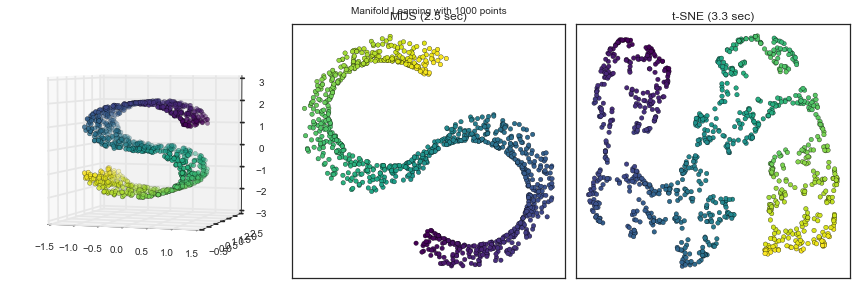

In [13]:

ipywidgets.interact(compare_mds_tsne, metric=['euclidean', 'cityblock', 'seuclidean', 'sqeuclidean', 'correlation'], 
                    tsne_init=['random', 'pca'], n_points=ipywidgets.IntSlider(value=1000, min=50, max=2000, step=50),
                    random_state=ipywidgets.IntSlider(value=0, min=0, max=10),
                    stddev=ipywidgets.FloatSlider(value=0, min=0, max=1, description='Add Noise'));

In [7]:
manifold.TSNE()

TSNE(angle=0.5, early_exaggeration=4.0, init='random', learning_rate=1000.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=30,
   perplexity=30.0, random_state=None, verbose=0)

In [8]:
scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X))

array([[ 0.        ,  2.14088995,  1.35780511, ...,  3.40809004,
         3.37963444,  4.63971911],
       [ 2.14088995,  0.        ,  0.86543971, ...,  3.27145552,
         3.6950729 ,  6.46299516],
       [ 1.35780511,  0.86543971,  0.        , ...,  3.42760865,
         3.68741238,  5.60778458],
       ..., 
       [ 3.40809004,  3.27145552,  3.42760865, ...,  0.        ,
         0.75552579,  7.76371128],
       [ 3.37963444,  3.6950729 ,  3.68741238, ...,  0.75552579,
         0.        ,  7.46345184],
       [ 4.63971911,  6.46299516,  5.60778458, ...,  7.76371128,
         7.46345184,  0.        ]])

The left shows the original data in three dimensions, a flat sheet that was folded into an "S"-curve.

The middle plot shows the three-dimensional data smushed to two dimensions using MDS. Notice that it maintains the exact shape of the curve

## Hierarchical clustering

### Distance metrics: Euclidean vs Manhattan
One important point of how you cluster data is which distance metric you use.

- Euclidean distance is what you learned in algebra class: $\sqrt{x^2 + y^2}$, but all the way to $N$ dimensions: $\sqrt{\sum_i^N x_i^2}$
- Manhattan distance (also called "taxicab geometry")

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Manhattan_distance.svg/2000px-Manhattan_distance.svg.png)

### Linkage methods: Ward, average, single, complete

In [9]:
import seaborn as sns

sns.clustermap?